# Compulsory 2 - Erlend Risvik

## Loading and preprocessing data 
Start by loading in the secret ID

In [1]:
import ast
import requests
import pandas as pd
from pyspark.sql import SparkSession
import os

SECRET_INFO = open("../NO_SYNC/weather_api", 'r').read().replace('\n', '')
SECRET_ID = ast.literal_eval(SECRET_INFO)["client_id"]

In CA1, we selected locality 12765.

Let's start by finding out the GPS coordinates of our locality

In [2]:
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("select localityno, lon, lat, municipality, name from fish_data_full").toPandas()

In [3]:
# Select the GPS coordinates of locality 12765, and separate them by space
lat = round(fish_data.loc[fish_data['localityno'] == 12765, 'lat'].values[0], 3)
lon = round(fish_data.loc[fish_data['localityno'] == 12765, 'lon'].values[0], 3)
# Select the municipality and name of the same locality

municipality = fish_data.loc[fish_data['localityno'] == 12765, 'municipality'].values[0]
name = fish_data.loc[fish_data['localityno'] == 12765, 'name'].values[0]

# print lon, lat, municipality, name in f string nicely
print(f"Lon: {lon:.4f}\nLat: {lat:.4f}\nMunicipality: {municipality}\nPlace: {name}")

Lon: 9.9740
Lat: 62.0940
Municipality: Folldal
Place: Aasen Gård


In [4]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
"geometry" : f"nearest(POINT({lon} {lat}))",
"nearestmaxcount": 15,
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [5]:
# Go through each json object in the data list, and print the shortname, id and distance
for item in data:
    print(f"Shortname: {item['shortName']}\nID: {item['id']}\nDistance: {item['distance']}\n")
    

Shortname: Grimse 
ID: SN9050
Distance: 3.55522119643

Shortname: Folldal 
ID: SN9160
Distance: 3.95215517934

Shortname: Folldal (Li bru)
ID: SN8780
Distance: 9.44318857176

Shortname: FV29 Gravbekklia
ID: SN9250
Distance: 16.62512550816

Shortname: Atnsjøen
ID: SN8720
Distance: 24.25914849366

Shortname: Einunna
ID: SN8970
Distance: 24.47754731071

Shortname: Hjerkinn
ID: SN9310
Distance: 26.478453523970003

Shortname: E6 Hjerkinn
ID: SN9303
Distance: 27.607994447699998

Shortname: E6 Avsjøen
ID: SN16620
Distance: 27.655905071

Shortname: E6 Grønbakken
ID: SN63940
Distance: 28.53821021009

Shortname: Alvdal 
ID: SN8880
Distance: 34.00673936603

Shortname: Høvringen
ID: SN16271
Distance: 34.483657391369995

Shortname: RV3 Bergerønningen
ID: SN9400
Distance: 34.70172348205

Shortname: E6 Fokstugu
ID: SN16611
Distance: 35.83972754819

Shortname: Fokstugu
ID: SN16610
Distance: 35.84706832411



In [6]:
# SN16610 contains the information needed
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN16610',
    'elements': 'sum(precipitation_amount P1D), mean(air_temperature P1D), mean(wind_speed P1D), mean(relative_humidity P1D)',
    'referencetime': '2015-01-01/2015-12-31',
    'levels' : 'default',
    'timeoffsets': 'default'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

In [7]:
# print lentgh of data
print(f"Length of data: {len(json['data'])}")


Length of data: 364


In [8]:
df = pd.DataFrame()
data = json['data']
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row], ignore_index=True)

df = df.reset_index(drop=True)

columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df2 = df[columns].copy()
df2['referenceTime'] = pd.to_datetime(df2['referenceTime']).dt.strftime('%Y-%m-%d')
df2

,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN16610:0,2015-01-01,sum(precipitation_amount P1D),0.1,mm,PT6H
1,SN16610:0,2015-01-01,mean(air_temperature P1D),0.9,degC,PT0H
2,SN16610:0,2015-01-01,mean(wind_speed P1D),5.7,m/s,PT0H
3,SN16610:0,2015-01-01,mean(relative_humidity P1D),76.0,percent,PT0H
4,SN16610:0,2015-01-02,sum(precipitation_amount P1D),2.2,mm,PT6H
...,...,...,...,...,...,...
1449,SN16610:0,2015-12-29,mean(relative_humidity P1D),83.0,percent,PT0H
1450,SN16610:0,2015-12-30,sum(precipitation_amount P1D),2.3,mm,PT6H
1451,SN16610:0,2015-12-30,mean(air_temperature P1D),-3.2,degC,PT0H
1452,SN16610:0,2015-12-30,mean(wind_speed P1D),16.1,m/s,PT0H


In [9]:
# convert from wide to long format
df3 = df2.pivot(index='referenceTime', columns='elementId', values='value').reset_index()
# give better column names
df3.columns = ['date', 'temperature', 'humidity', 'wind_speed', 'precipitation']
df3

,date,temperature,humidity,wind_speed,precipitation
0,2015-01-01,0.9,76.0,5.7,0.1
1,2015-01-02,-3.1,91.0,6.7,2.2
2,2015-01-03,-6.3,96.0,4.4,5.8
3,2015-01-04,-7.4,92.0,4.3,0.3
4,2015-01-05,-4.7,89.0,1.5,0.4
...,...,...,...,...,...
359,2015-12-26,-10.3,83.0,3.5,1.6
360,2015-12-27,-11.0,71.0,2.5,0.0
361,2015-12-28,-10.6,79.0,2.0,0.4
362,2015-12-29,-6.1,83.0,8.7,0.0


In [10]:
# check for missing values
df3.isnull().sum()

date             0
temperature      0
humidity         0
wind_speed       2
precipitation    0
dtype: int64

Acceptable amount!

## Writing data to spark

In [11]:
from pyspark.sql import SparkSession
import os

# Set pyspark env
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

def list_tables():
    """
    Function to list all tables in cassandra
    """
    query = "SELECT * FROM system_schema.tables WHERE keyspace_name='compulsory';"
    rows = session.execute(query)
    for i in rows:
        print(i)

In [12]:
list_tables()

Row(keyspace_name='compulsory', table_name='car_table', additional_write_policy='99p', bloom_filter_fp_chance=0.01, caching=OrderedMapSerializedKey([('keys', 'ALL'), ('rows_per_partition', 'NONE')]), cdc=None, comment='', compaction=OrderedMapSerializedKey([('class', 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy'), ('max_threshold', '32'), ('min_threshold', '4')]), compression=OrderedMapSerializedKey([('chunk_length_in_kb', '16'), ('class', 'org.apache.cassandra.io.compress.LZ4Compressor')]), crc_check_chance=1.0, dclocal_read_repair_chance=0.0, default_time_to_live=0, extensions=OrderedMapSerializedKey([]), flags=SortedSet(['compound']), gc_grace_seconds=864000, id=UUID('945dbc40-5954-11ee-8bb8-2f03669fdb2b'), max_index_interval=2048, memtable=None, memtable_flush_period_in_ms=0, min_index_interval=128, read_repair='BLOCKING', read_repair_chance=0.0, speculative_retry='99p')
Row(keyspace_name='compulsory', table_name='fish_data_full', additional_write_policy='99p', 

In [13]:
weather_spark = convert_to_spark(df3)

# create unique id for each row
#from pyspark.sql.functions import monotonically_increasing_id
#weather_spark = weather_spark.withColumn("id", monotonically_increasing_id())

In [14]:
weather_spark.show()

+----------+-----------+--------+----------+-------------+
|      date|temperature|humidity|wind_speed|precipitation|
+----------+-----------+--------+----------+-------------+
|2015-01-01|        0.9|    76.0|       5.7|          0.1|
|2015-01-02|       -3.1|    91.0|       6.7|          2.2|
|2015-01-03|       -6.3|    96.0|       4.4|          5.8|
|2015-01-04|       -7.4|    92.0|       4.3|          0.3|
|2015-01-05|       -4.7|    89.0|       1.5|          0.4|
|2015-01-06|       -2.6|    93.0|       6.1|          3.2|
|2015-01-07|       -4.1|    88.0|       5.5|          0.0|
|2015-01-08|       -2.3|    75.0|       5.8|          0.0|
|2015-01-09|       -9.3|    81.0|       1.8|          0.0|
|2015-01-10|       -8.1|    89.0|       5.5|          0.1|
|2015-01-11|       -9.3|    89.0|       2.1|          8.6|
|2015-01-12|       -7.7|    85.0|       4.3|          1.1|
|2015-01-13|       -4.5|    77.0|       7.1|          1.7|
|2015-01-14|       -5.2|    70.0|       7.1|          0.

In [15]:
# print length of weather_spark
print(f"Length of weather_spark: {weather_spark.count()}")

Length of weather_spark: 364


In [16]:
cassandra_types = {
    'temperature': 'float',
    'humidity': 'float',
    'wind_speed': 'float',
    'precipitation': 'float'
}

table_name = "weather_data"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        date text PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types[i]}" for i in weather_spark.columns if i != "date"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name};")
session.execute(cql_create_table)

In [17]:
(weather_spark
.write
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.mode("append")
.save())

In [18]:
weather_spark.show()

+----------+-----------+--------+----------+-------------+
|      date|temperature|humidity|wind_speed|precipitation|
+----------+-----------+--------+----------+-------------+
|2015-01-01|        0.9|    76.0|       5.7|          0.1|
|2015-01-02|       -3.1|    91.0|       6.7|          2.2|
|2015-01-03|       -6.3|    96.0|       4.4|          5.8|
|2015-01-04|       -7.4|    92.0|       4.3|          0.3|
|2015-01-05|       -4.7|    89.0|       1.5|          0.4|
|2015-01-06|       -2.6|    93.0|       6.1|          3.2|
|2015-01-07|       -4.1|    88.0|       5.5|          0.0|
|2015-01-08|       -2.3|    75.0|       5.8|          0.0|
|2015-01-09|       -9.3|    81.0|       1.8|          0.0|
|2015-01-10|       -8.1|    89.0|       5.5|          0.1|
|2015-01-11|       -9.3|    89.0|       2.1|          8.6|
|2015-01-12|       -7.7|    85.0|       4.3|          1.1|
|2015-01-13|       -4.5|    77.0|       7.1|          1.7|
|2015-01-14|       -5.2|    70.0|       7.1|          0.

In [19]:
# shut down the connection
#session.shutdown()
#cluster.shutdown()

## Loading data from spark

In [20]:
from pyspark.sql import SparkSession
import pandas as pd
import os

os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Reading the weather data from cassandra 
table_name = "weather_data"

(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

weather_data = spark.sql(f"select * from {table_name}").toPandas()
weather_data.head()

,date,humidity,precipitation,temperature,wind_speed
0,2015-09-01,73.0,0.0,7.7,3.1
1,2015-01-05,89.0,0.4,-4.7,1.5
2,2015-11-12,82.0,0.5,-1.8,1.6
3,2015-10-04,73.0,0.0,4.4,2.3
4,2015-09-15,81.0,0.0,8.1,5.3


In [21]:
# Sort values by date
weather_data['date'] = pd.to_datetime(weather_data['date'])

weather_data = weather_data.sort_values(by='date')
weather_data.head()

,date,humidity,precipitation,temperature,wind_speed
107,2015-01-01,76.0,0.1,0.9,5.7
236,2015-01-02,91.0,2.2,-3.1,6.7
95,2015-01-03,96.0,5.8,-6.3,4.4
245,2015-01-04,92.0,0.3,-7.4,4.3
1,2015-01-05,89.0,0.4,-4.7,1.5


In [22]:
table_name = "lice_data_full"

(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

lice_data = spark.sql(f"select * from {table_name}").toPandas()
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
0,187283,0.00,0.02,0.00,False,False,False,False,True,True,False,False,24175,5.2,20,2015
1,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015
2,187265,0.00,0.00,0.00,False,False,False,False,True,True,False,False,24175,5.0,2,2015
3,187280,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.9,17,2015
4,187282,0.01,0.03,0.05,False,False,False,False,True,True,False,False,24175,4.5,19,2015


In [23]:
lice_data = lice_data.sort_values(by='week')
lice_data.tail()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
48,187311,0.04,0.05,1.14,False,True,False,False,True,True,False,False,24175,7.0,48,2015
30,187312,0.03,0.19,0.21,False,True,False,False,True,True,False,False,24175,6.5,49,2015
37,187313,0.03,0.13,0.30,False,True,False,False,True,True,False,False,24175,6.0,50,2015
44,187314,0.01,0.22,0.42,False,True,False,False,True,True,False,False,24175,5.0,51,2015
1,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015


In [24]:
# set week as index
lice_data = lice_data.set_index('week')
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,year
week,,,,,,,,,,,,,,,
1,187264,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,5.3,2015
2,187265,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,5.0,2015
3,187266,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,4.5,2015
4,187267,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,4.5,2015
5,187268,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.7,2015


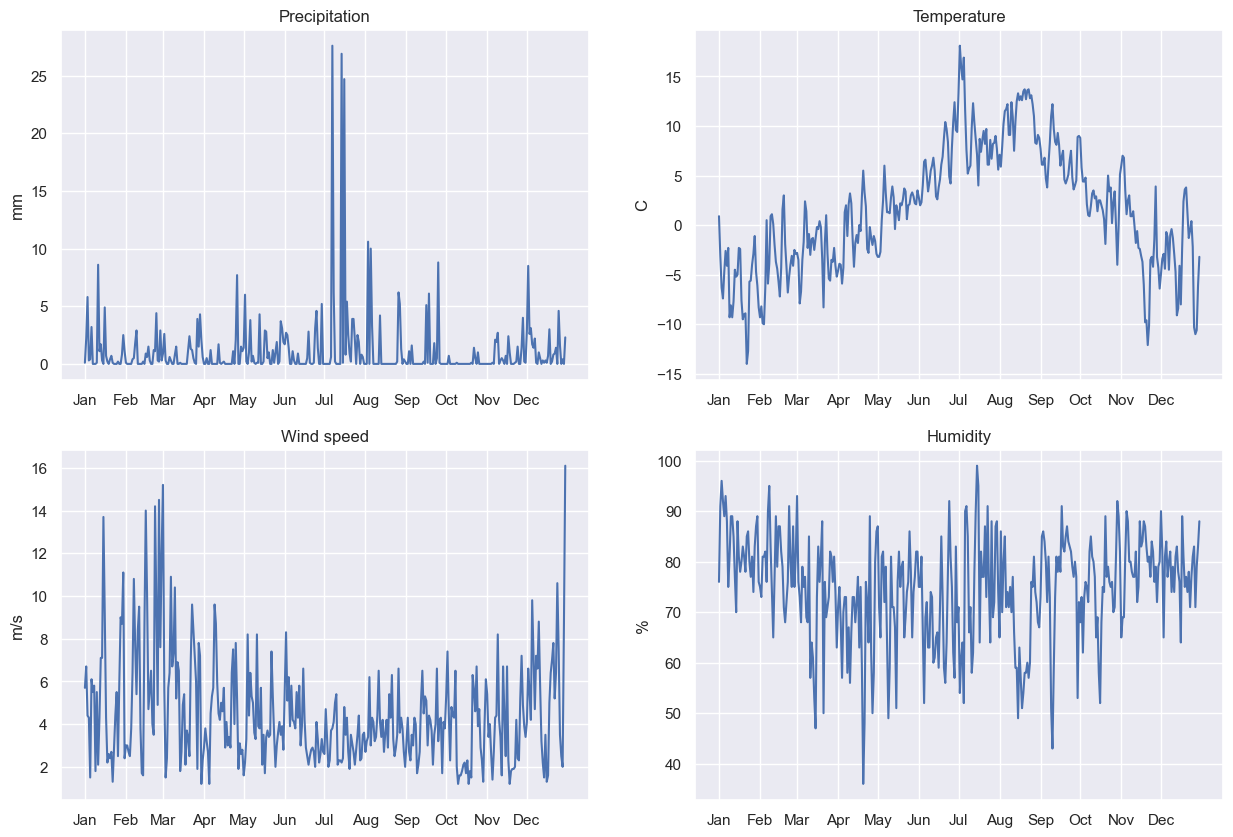

In [25]:
# plot the four variables
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ticks = ['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01']
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.lineplot(ax=axes[0, 0], data=weather_data, x='date', y='precipitation')
axes[0, 0].set_title('Precipitation')
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_ylabel('mm')

sns.lineplot(ax=axes[0, 1], data=weather_data, x='date', y='temperature')
axes[0, 1].set_title('Temperature')
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_ylabel('C')

sns.lineplot(ax=axes[1, 0], data=weather_data, x='date', y='wind_speed')
axes[1, 0].set_title('Wind speed')
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].set_ylabel('m/s')

sns.lineplot(ax=axes[1, 1], data=weather_data, x='date', y='humidity')
axes[1, 1].set_title('Humidity')
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('%')

# hide the x label "date"
for ax in axes.flat:
    ax.set(xlabel='')

## Noise, outliers and pre-procecssing

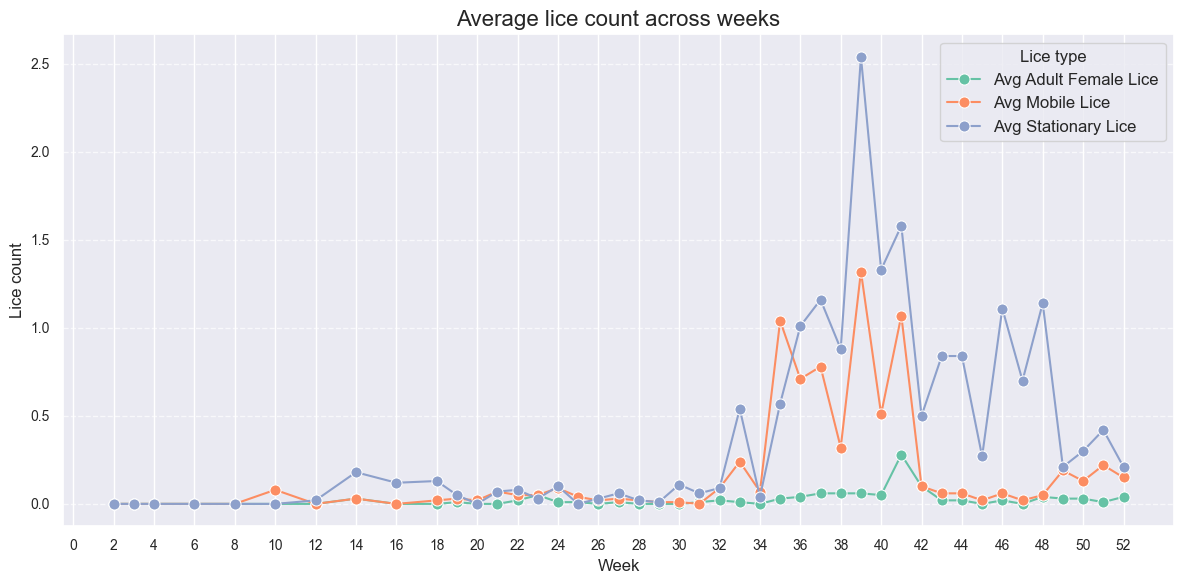

In [26]:
# We start by plotting the data first to see how it looks like
# Plot each of the three lice columns across time

import numpy as np
custom_palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='avgadultfemalelice', data=lice_data, marker='o',\
              markersize=8, label='Avg Adult Female Lice', color=custom_palette[0])
sns.lineplot(x='week', y='avgmobilelice', data=lice_data, marker='o',\
              markersize=8, label='Avg Mobile Lice', color=custom_palette[1])
sns.lineplot(x='week', y='avgstationarylice', data=lice_data, marker='o',\
              markersize=8, label='Avg Stationary Lice', color=custom_palette[2])

plt.title('Average lice count across weeks', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Lice count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(np.arange(0, 53, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Lice type', fontsize=12)
plt.tight_layout()

plt.show()

In [27]:
from pybaselines.whittaker import asls
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

# impute 0 where na
lice_data = lice_data.fillna(0)

# use asls smoothing and apply it to  each of avgAdultFemaleLice, avgMobileLice and avgStationaryLice.
# Put the raw series and smoothed series together as columns in a Pandas DataFrame (6 columns in total) and use the timestamps as the index (week).

# create a new dataframe "smoothed" with the week column as index. It is supposed to be empty.
smoothed = pd.DataFrame(index=lice_data.index)
#y_whit, params = asls(lice_data['avgadultfemalelice'].values, lam=10**-2, p=0.5)
#y_whit = gaussian_filter1d(lice_data['avgadultfemalelice'].values, sigma=1.5)
y_smooth = savgol_filter(lice_data['avgadultfemalelice'].values, 5, 2)
smoothed['avgadultfemalelice_smooth'] = y_smooth
#y_whit, params = asls(lice_data['avgmobilelice'].values, lam=100, p=0.2)
#y_whit = gaussian_filter1d(lice_data['avgmobilelice'].values, sigma=0.6)
y_smooth = savgol_filter(lice_data['avgmobilelice'].values, 5, 3)
smoothed['avgmobilelice_smooth'] = y_smooth
#y_whit, params = asls(lice_data['avgstationarylice'].values, lam=100, p=0.2)
#y_whit = gaussian_filter1d(lice_data['avgstationarylice'].values, sigma=1.2)
y_smooth = savgol_filter(lice_data['avgstationarylice'].values, 7, 3)
smoothed['avgstationarylice_smooth'] = y_smooth

# merge the three original columns with the three smoothed columns into one dataframe on "week"
smoothed = pd.merge(lice_data[["avgadultfemalelice", "avgmobilelice", "avgstationarylice"]], smoothed, left_index=True, right_index=True)
smoothed.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth
week,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Compute the robust means and robust covariance of the original data
import scipy.stats as stats
from sklearn.covariance import MinCovDet

# Compute regular mean and print
regular_means = lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].mean()
print(f"Regular means:\n{regular_means}")

# compute robust mean and print
robust_means = lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].apply(stats.trim_mean, axis=0, proportiontocut=0.05)
print(f"Robust means:\n{robust_means}")

# Compute regular covariance and print
cov = np.cov(lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].T)
print(f"Regular covariance:\n{cov}")

# Print robust covariance using MCD and print
mcd = MinCovDet(random_state=1).fit(lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']])
mcd_mean = mcd.location_
mcd_cov = mcd.covariance_

print(f"Robust covariance:\n{mcd_cov}")

Regular means:
avgadultfemalelice    0.020577
avgmobilelice         0.149615
avgstationarylice     0.333654
dtype: float32
Robust means:
avgadultfemalelice    0.014375
avgmobilelice         0.112292
avgstationarylice     0.275625
dtype: float32
Regular covariance:
[[0.00182907 0.00811199 0.0133704 ]
 [0.00811199 0.08880377 0.12337594]
 [0.0133704  0.12337594 0.27282756]]
Robust covariance:
[[3.35067623e-05 9.07388147e-05 1.04058272e-04]
 [9.07388147e-05 8.53902212e-04 5.20707625e-04]
 [1.04058272e-04 5.20707625e-04 1.75109258e-03]]


The robust mean is slightly different, but the covariance is very different. 

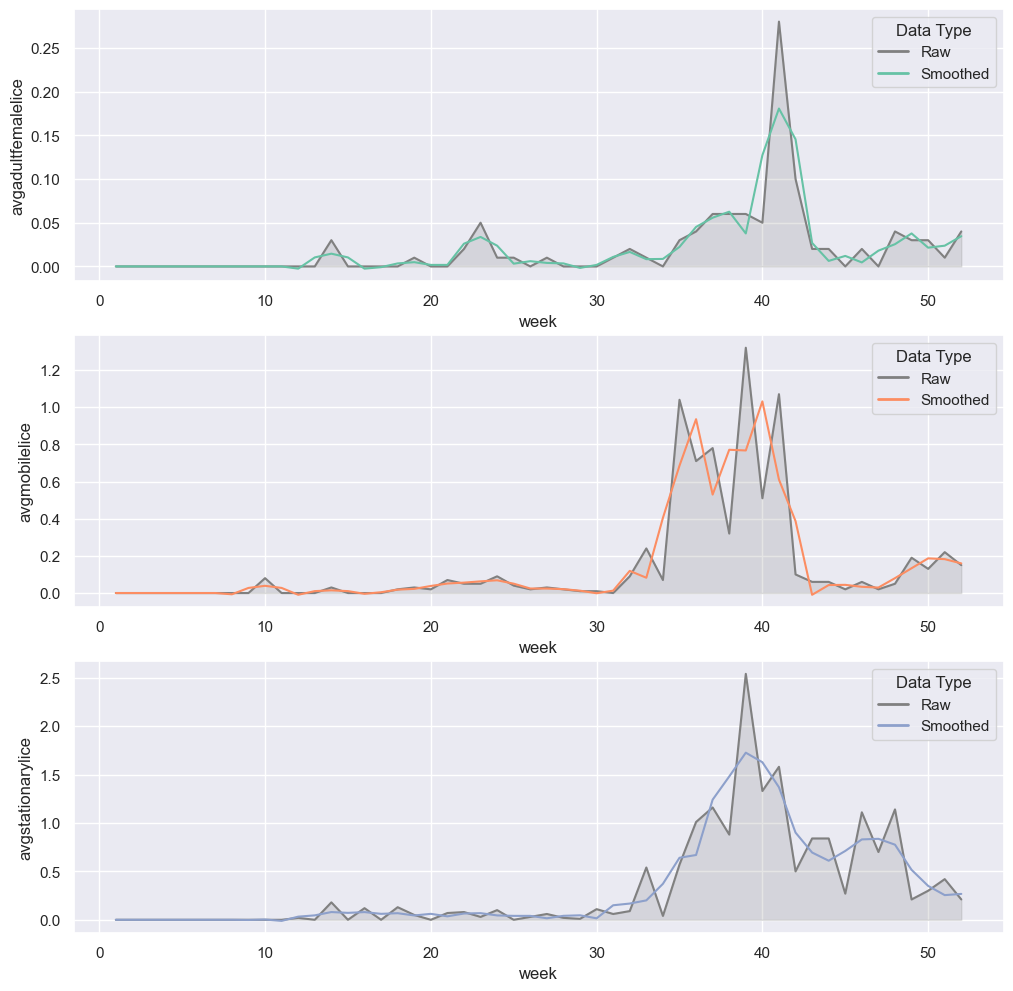

In [65]:
from matplotlib.lines import Line2D

# Plotting the smoothed series and raw series
custom_palette = sns.color_palette("Set2")

def legend_elements(ax):
    return [Line2D([0], [0], color='grey', lw=2, label='Raw'),
        Line2D([0], [0], color=custom_palette[ax], lw=2, label='Smoothed')]



# plotting the raw data as lineplot
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(ax=axes[0], x='week', y='avgadultfemalelice', data=smoothed, color='grey')
sns.lineplot(ax=axes[1], x='week', y='avgmobilelice', data=smoothed, color='grey')
sns.lineplot(ax=axes[2], x='week', y='avgstationarylice', data=smoothed, color='grey')

# adding shadow
axes[0].fill_between(smoothed.index, smoothed['avgadultfemalelice'], color='grey', alpha=0.2)
axes[1].fill_between(smoothed.index, smoothed['avgmobilelice'], color='grey', alpha=0.2)
axes[2].fill_between(smoothed.index, smoothed['avgstationarylice'], color='grey', alpha=0.2)

# plotting the smoothed data
sns.lineplot(ax=axes[0], x='week', y='avgadultfemalelice_smooth', data=smoothed, color=custom_palette[0])
sns.lineplot(ax=axes[1], x='week', y='avgmobilelice_smooth', data=smoothed, color=custom_palette[1])
sns.lineplot(ax=axes[2], x='week', y='avgstationarylice_smooth', data=smoothed, color=custom_palette[2])

# Add legend to the plot indicating shadow is true data and colored is smoothed data
#legend_colors = {'Raw': 'grey', 'Smoothed': custom_palette[0]}
#legend_labels = ['Raw', 'Smoothed']

axes[0].legend(handles=legend_elements(0), title='Data Type')
axes[1].legend(handles=legend_elements(1), title='Data Type')
axes[2].legend(handles=legend_elements(2), title='Data Type')

We can see that the smoothing attempts to average out the noise in the data. It is challenging to choose the hyperparameters for smoothing because we don't know if the peaks are noise or useful information. That is why i chose to use a smoothing method that is not too aggressive.

In [97]:
def Hotellings_T2(X, mean, cov, n, alpha = 0.01):
    T2 = np.sum(((X-mean) @ np.linalg.inv(cov)) * (X-mean), axis=-1)
    p = len(mean)
    F = (n-p)/(p*(n-1))*T2
    P = stats.f.sf(F, p, n-p)
    # Critical value
    c = stats.f.isf(alpha, p, n-p)*p*(n-1)/(n-p)
    return (T2, F, P, c)

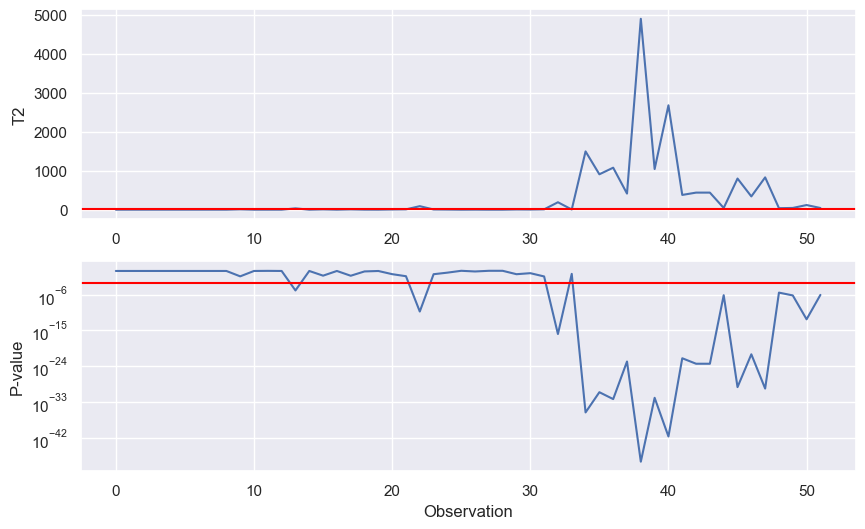

In [98]:
# Apply Hotellings_T2 and plotting
cols = ['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']

alpha = 0.001
# We use the robust mean and covariance to utilize the whole data
T2, F, P, c = Hotellings_T2(lice_data[cols].values, mcd_mean, mcd_cov, 52, alpha)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(T2)
plt.grid(True)
plt.axhline(c, color="red")
#plt.axvline(42, color="orange")
plt.ylabel("T2")
plt.subplot(212)
# Plot P on a logarithmic scale
plt.plot(P)
plt.yscale("log")
plt.grid(True)
plt.axhline(alpha, color="red")
#plt.axvline(42, color="orange")
plt.ylabel("P-value")
plt.xlabel("Observation")
plt.show()

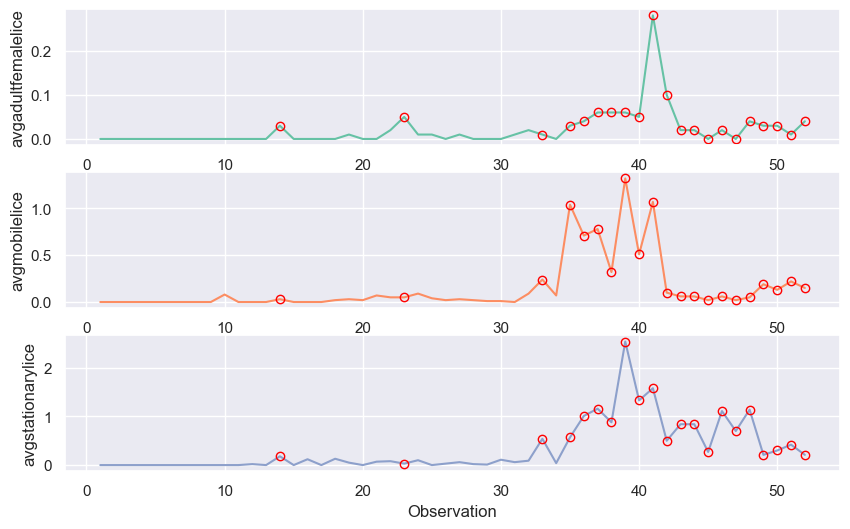

In [99]:
# Plotting the outliers as red circles
x = np.arange(1,53)+0.0
x[P>alpha] = np.nan

plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(smoothed[cols[0]], '-', color=custom_palette[0])
plt.plot(x, smoothed[cols[0]], 'o', markeredgecolor='red', markerfacecolor='none')
plt.ylabel(cols[0])
plt.subplot(312)
plt.plot(smoothed[cols[1]], '-', color=custom_palette[1])
plt.plot(x, smoothed[cols[1]], 'o', markeredgecolor='red', markerfacecolor='none', )
plt.ylabel(cols[1])
plt.subplot(313)
plt.plot(smoothed[cols[2]], '-', color=custom_palette[2])
plt.plot(x, smoothed[cols[2]], 'o', markeredgecolor='red', markerfacecolor='none')
plt.ylabel(cols[2])
plt.xlabel('Observation')
plt.show()

In [103]:
# Check how many observations are remaining
np.isnan(x).sum()

31

Because the covariance was so small, we mark a large majority of the samples as outliers. This occurs because most values in the dataset is 0, with some between 0 and 1, whereas after week 30-35 the data has spikes.

## Merging data and writing to spark

In [34]:
# convert the index of the weather_data DataFrame to a DatetimeIndex
weather_data.index = pd.to_datetime(weather_data.index)

# create a week column using the isocalendar method
weather_data['week'] = weather_data['date'].dt.isocalendar().week

# create the weekly_weather_data_mean DataFrame where we aggregate by weekly means
weekly_weather_data_mean = pd.DataFrame()
weekly_weather_data_mean['week'] = weather_data['week']
weekly_weather_data_mean['humidity'] = weather_data['humidity']
weekly_weather_data_mean['temperature'] = weather_data['temperature']
weekly_weather_data_mean['wind_speed'] = weather_data['wind_speed']
weekly_weather_data_mean = weekly_weather_data_mean.groupby('week').mean()

# same for precipitation, but we use weekly sum
weekly_weather_data_sum = pd.DataFrame()
weekly_weather_data_sum['week'] = weather_data['week']
weekly_weather_data_sum['precipitation'] = weather_data['precipitation']
weekly_weather_data_sum = weekly_weather_data_sum.groupby('week').sum()

weekly_weather_data = pd.merge(weekly_weather_data_mean, weekly_weather_data_sum, left_index=True, right_index=True)
weekly_weather_data.head()

,humidity,temperature,wind_speed,precipitation
week,,,,
1,88.750000,-3.975000,5.275000,8.400001
2,86.285713,-5.771429,4.042857,12.300000
3,79.857140,-4.957143,6.842857,8.900001
4,81.428574,-9.342857,3.114286,1.200000
5,80.714287,-5.200000,6.085714,4.700000


In [35]:
# join "smoothed" df and weekly_weather_data df on "week"
complete_data = pd.merge(smoothed, weekly_weather_data, left_index=True, right_index=True)
complete_data.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth,humidity,temperature,wind_speed,precipitation
week,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,88.750000,-3.975000,5.275000,8.400001
2,0.0,0.0,0.0,0.0,0.0,0.0,86.285713,-5.771429,4.042857,12.300000
3,0.0,0.0,0.0,0.0,0.0,0.0,79.857140,-4.957143,6.842857,8.900001
4,0.0,0.0,0.0,0.0,0.0,0.0,81.428574,-9.342857,3.114286,1.200000
5,0.0,0.0,0.0,0.0,0.0,0.0,80.714287,-5.200000,6.085714,4.700000


In [36]:
complete_data.tail()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth,humidity,temperature,wind_speed,precipitation
week,,,,,,,,,,
48,0.04,0.05,1.14,0.025429,0.080000,0.775714,78.428574,-2.271429,4.300000,7.300000
49,0.03,0.19,0.21,0.037714,0.133429,0.515714,79.857140,-3.414286,5.828571,20.299999
50,0.03,0.13,0.30,0.021429,0.186571,0.349762,79.000000,-3.414286,5.500000,4.100000
51,0.01,0.22,0.42,0.023714,0.182286,0.254762,77.142860,-1.857143,3.757143,4.400000
52,0.04,0.15,0.21,0.034571,0.159429,0.267381,76.428574,-3.371429,6.214286,9.300000


In [37]:
from pyspark.sql import SparkSession
import os

# Set pyspark env
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

In [38]:
# set week as colmn from index
complete_data['week'] = complete_data.index


In [39]:
from pyspark.sql.functions import col

lice_weather_spark = convert_to_spark(complete_data).withColumn("week", col("week").cast("int"))
lice_weather_spark.show()

+--------------------+--------------------+--------------------+-------------------------+--------------------+------------------------+-----------------+-------------------+------------------+------------------+----+
|  avgadultfemalelice|       avgmobilelice|   avgstationarylice|avgadultfemalelice_smooth|avgmobilelice_smooth|avgstationarylice_smooth|         humidity|        temperature|        wind_speed|     precipitation|week|
+--------------------+--------------------+--------------------+-------------------------+--------------------+------------------------+-----------------+-------------------+------------------+------------------+----+
|                 0.0|                 0.0|                 0.0|                      0.0|                 0.0|                     0.0|            88.75|-3.9749999046325684| 5.275000095367432|  8.40000057220459|   1|
|                 0.0|                 0.0|                 0.0|                      0.0|                 0.0|                 

In [40]:
cassandra_types = {
    'temperature': 'float',
    'humidity': 'float',
    'wind_speed': 'float',
    'precipitation': 'float',
    'avgadultfemalelice': 'float',
    'avgmobilelice': 'float',
    'avgstationarylice': 'float',
    'avgadultfemalelice_smooth': 'float',
    'avgmobilelice_smooth': 'float',
    'avgstationarylice_smooth': 'float'
}

table_name = "lice_weather_data"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        week int PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types[i]}" for i in lice_weather_spark.columns if i != "week"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name};")
session.execute(cql_create_table)

In [41]:
(lice_weather_spark
.write
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.mode("append")
.save())

In [42]:
lice_weather_spark.show()

+--------------------+--------------------+--------------------+-------------------------+--------------------+------------------------+-----------------+-------------------+------------------+------------------+----+
|  avgadultfemalelice|       avgmobilelice|   avgstationarylice|avgadultfemalelice_smooth|avgmobilelice_smooth|avgstationarylice_smooth|         humidity|        temperature|        wind_speed|     precipitation|week|
+--------------------+--------------------+--------------------+-------------------------+--------------------+------------------------+-----------------+-------------------+------------------+------------------+----+
|                 0.0|                 0.0|                 0.0|                      0.0|                 0.0|                     0.0|            88.75|-3.9749999046325684| 5.275000095367432|  8.40000057220459|   1|
|                 0.0|                 0.0|                 0.0|                      0.0|                 0.0|                 

## Test if loading data works

In [43]:
(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

test = spark.sql(f"select * from {table_name}").toPandas().sort_values(by='week')
test.head()

,week,avgadultfemalelice,avgadultfemalelice_smooth,avgmobilelice,avgmobilelice_smooth,avgstationarylice,avgstationarylice_smooth,humidity,precipitation,temperature,wind_speed
43,1,0.0,0.0,0.0,0.0,0.0,0.0,88.750000,8.400001,-3.975000,5.275000
31,2,0.0,0.0,0.0,0.0,0.0,0.0,86.285713,12.300000,-5.771429,4.042857
49,3,0.0,0.0,0.0,0.0,0.0,0.0,79.857140,8.900001,-4.957143,6.842857
25,4,0.0,0.0,0.0,0.0,0.0,0.0,81.428574,1.200000,-9.342857,3.114286
9,5,0.0,0.0,0.0,0.0,0.0,0.0,80.714287,4.700000,-5.200000,6.085714
